In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from zipfile import ZipFile
import cv2

In [55]:
with ZipFile(r'Machine-Learning\Image_classification_data.zip', 'r') as zipobj:
    zipobj.extractall('colon_data')


In [56]:
image_dir = 'colon_data'
print(os.listdir(image_dir))

['data_labels_extraData.csv', 'data_labels_mainData.csv', 'patch_images', '__MACOSX']


In [57]:
#Loading CSV
df2 = pd.read_csv('colon_data/data_labels_mainData.csv')
df1 = pd.read_csv('colon_data/data_labels_extraData.csv')

In [58]:
df2.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [59]:
df1.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


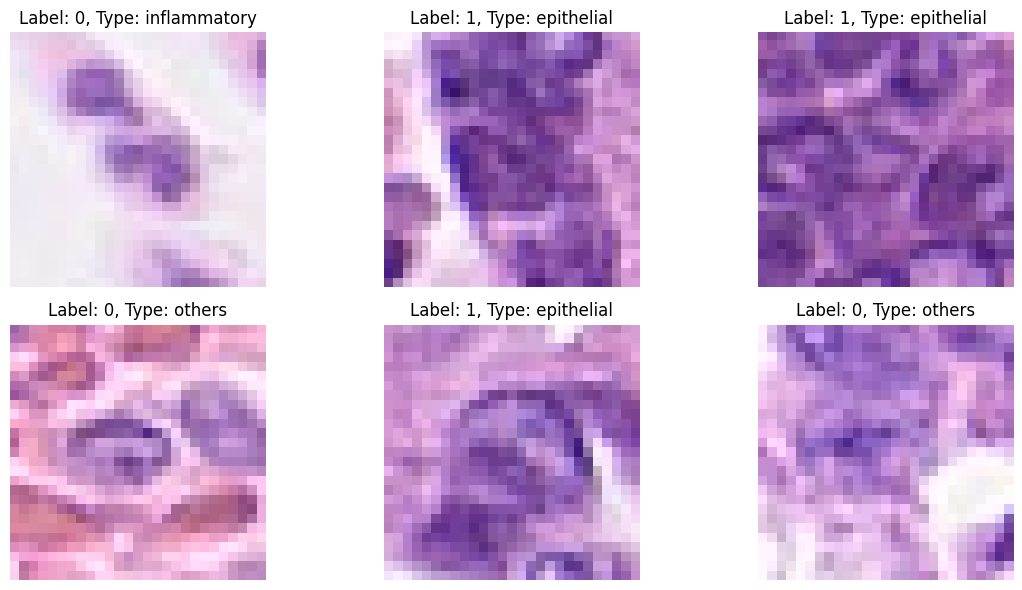

In [60]:
image_dir = 'colon_data/patch_images'

def display_sample_images(df, num_samples=6):
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['ImageName'])
        img = Image.open(img_path)
 
        # Dynamically build the title
        title = f"Label: {row['isCancerous']}"
        if 'cellTypeName' in row:
            title += f", Type: {row['cellTypeName']}"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display samples from main_df(df2)
display_sample_images(df2)

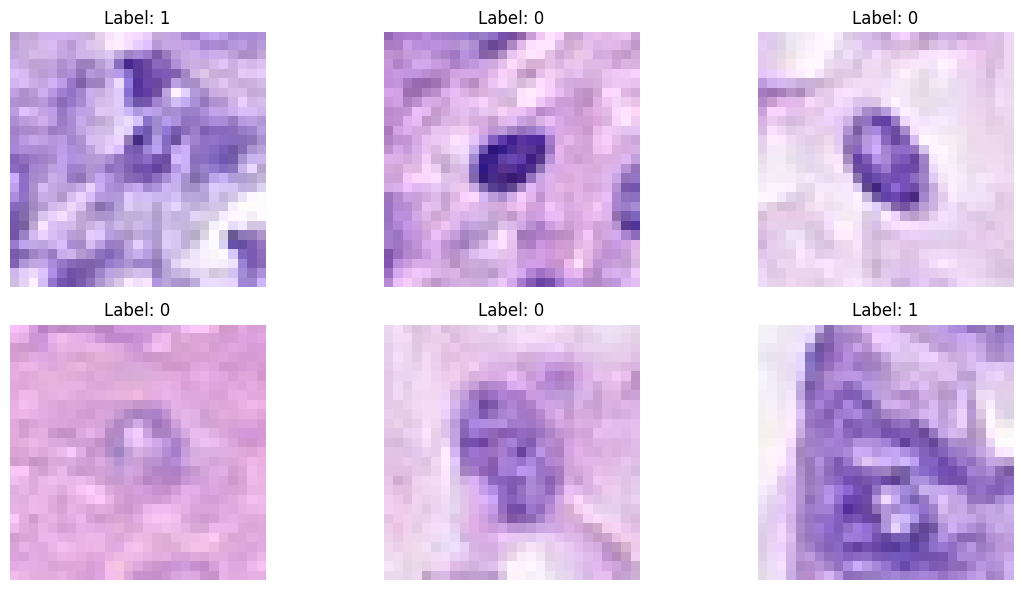

In [61]:
display_sample_images(df1)

# Exploratory Data Analysis

# Relationship Between Cell Type and Cancer Status

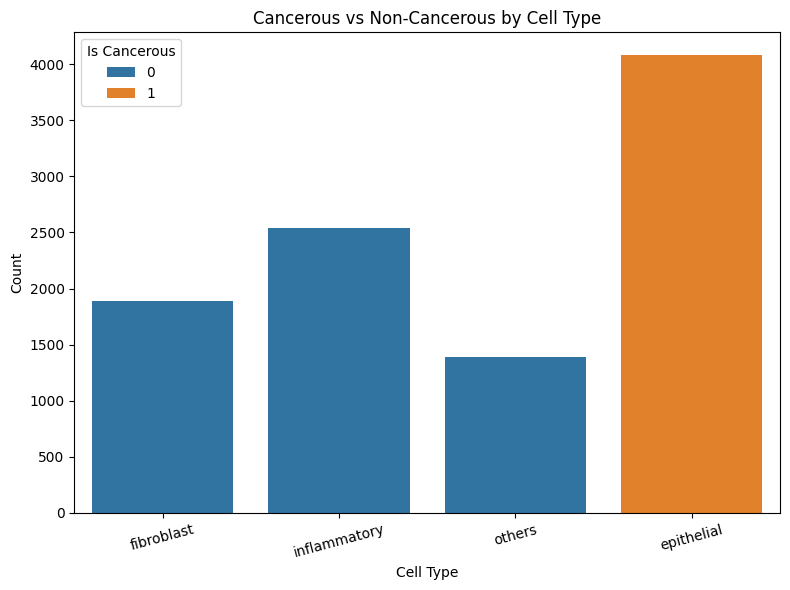

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=df2)
plt.title('Cancerous vs Non-Cancerous by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='Is Cancerous')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Key Insights

The grouped bar chart illustrates the distribution of cancerous (1) and non-cancerous (0) labels across different cell types.

- Nearly all **epithelial** cells are labeled as cancerous.
- In contrast, **fibroblast**, **inflammatory**, and **others** are predominantly non-cancerous.

# Distribution of Cancer labels in Main vs Extra Data

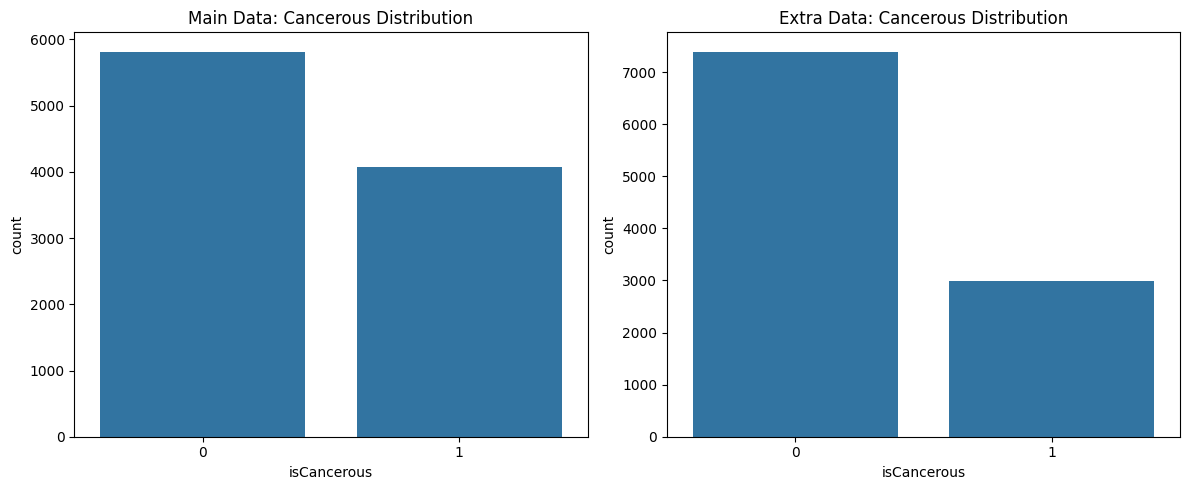

In [63]:
# Check cancerous label distribution in main and extra data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='isCancerous', data=df2, ax=axs[0])
axs[0].set_title('Main Data: Cancerous Distribution')

sns.countplot(x='isCancerous', data=df1, ax=axs[1])
axs[1].set_title('Extra Data: Cancerous Distribution')

plt.tight_layout()
plt.show()


### Observations
The bar charts illustrate the distribution of cancerous (1) and non-cancerous (0) labels in both the Main Data and Extra Data.
- In the Main Data, the count of non-cancerous samples (0) is noticeably higher than the count of cancerous samples (1), indicating a class imbalance.
- Similar pattern is observed in the Extra Data, where non-cancerous samples are also more prevalent than cancerous ones.

# Missing Values Check

In [64]:
print("Missing values in df2:")
print(df2.isnull().sum())

print("\nMissing values in df1:")
print(df1.isnull().sum())

Missing values in df2:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

Missing values in df1:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


### Result:
This displays the count of missing values per column in both the Main Data (df2) and Extra Data (df1).
- There are no missings values found in any dataset

# Image Shape and Channel Analysis

100%|██████████| 9896/9896 [01:17<00:00, 126.97it/s]


        Width  Height  Channels
count  9896.0  9896.0    9896.0
mean     27.0    27.0       3.0
std       0.0     0.0       0.0
min      27.0    27.0       3.0
25%      27.0    27.0       3.0
50%      27.0    27.0       3.0
75%      27.0    27.0       3.0
max      27.0    27.0       3.0


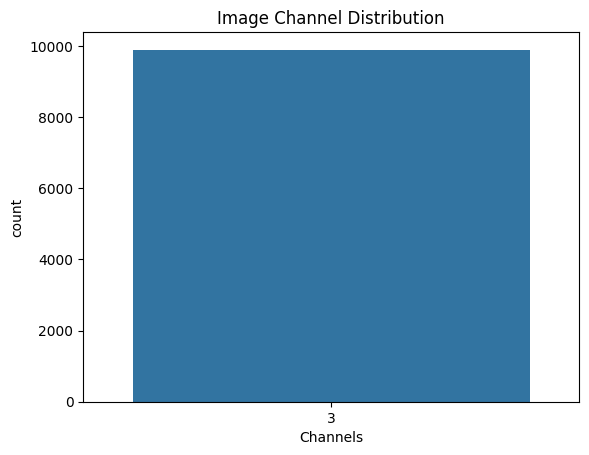

In [65]:
from tqdm import tqdm

def get_image_shapes(df):
    shapes = []
    for img_name in tqdm(df['ImageName']):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        shapes.append(img.size + (len(img.getbands()),))  # (width, height, channels)
    return shapes

shapes_main = get_image_shapes(df2)
shapes_df = pd.DataFrame(shapes_main, columns=['Width', 'Height', 'Channels'])
print(shapes_df.describe())

sns.countplot(x='Channels', data=shapes_df)
plt.title('Image Channel Distribution')
plt.show()

### Observations
This analysis examined the dimensions and channel configuration of all 9,896 images in the dataset using the tqdm progress bar to track processing.
- All images have the same dimensions of 27x27 pixels.
- Each image has 3 channels, suggesting that they are RGB colour images.
- The seaborn countplot of the Channels column shows a single bar at 3, reinforcing that all images are in color and none are grayscale (1 channel) or RGBA (4 channels).

# Class Distribution in Combined Dataset

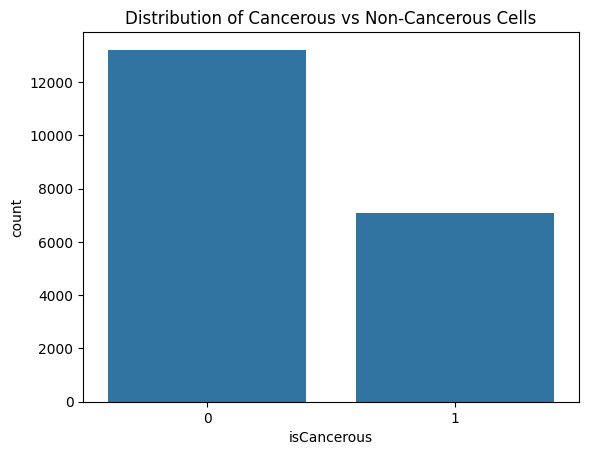

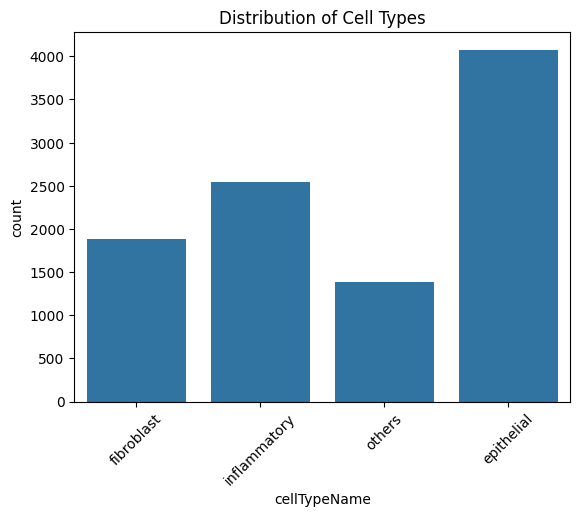

In [66]:
sns.countplot(x='isCancerous', data=dfcancer)
plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
plt.show()

# cellType distribution
sns.countplot(x='cellTypeName', data=df2)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

1. ***isCancerous Distribution:***
The bar chart for the isCancerous label shows a noticeable class imbalance.

The majority of samples are non-cancerous (label 0), accounting for 13211 samples.

In contrast, cancerous (label 1) samples total just around 7069.

**Implication**: If left unaddressed, this imbalance can cause a binary classifier to be biased toward predicting the majority class (non-cancerous), potentially leading to high accuracy but poor recall for the cancerous class — which is medically critical.

2. ***Cell Type Distribution:***
The distribution of cellTypeName reveals a moderate class imbalance:

The epithelial category is the most represented, with more than 4,000 instances.

In contrast, classes such as others and fibroblast have less than 2,000 samples each.

**Implication**: In a multi-class classification task, this imbalance may lead the model to favor the dominant class (epithelial), while performing poorly on underrepresented categories. This could negatively impact metrics like the macro F1-score and reduce the model's ability to generalize across all classes.

# **✅ Techniques we will use to Handle Class Imbalance**

1.**Data Augmentation (for minority classes):** So what it does is basically it artificially increases the size of underrepresented classes by creating modified versions of their images.

2.**Class Weights**: Assign higher importance to minority classes during training.


We will deal with the class imbalance later in the codes as before that we wanna deal with the preprocessing first

# **Baseline CNN & Data Preprocessing Experimentation**

### Loading Data
Since we are developing two distinct machine learning models—one for predicting cell type and another for identifying whether a cell is cancerous—we will first extract only the relevant columns which would be used for predictions (ImageName, isCancerous) from df1 and then append (concatenate) them to df2 so that we have a unified dataset to work with.

So we will make 2 dataframes (dfcancer) and another dfcell)

In [67]:
dfcancer = pd.concat([df2[['ImageName', 'isCancerous']],df1[['ImageName', 'isCancerous']]],axis = 0)
dfcell = df2[['ImageName','cellType']]

SPLITTING THE DATASET INTO TRAIN AND TEST dataset(80% training data  ,20% test data)

In [68]:
traindfcancer, testdfcancer = train_test_split(
    dfcancer, test_size=0.2, random_state=42, stratify=dfcancer['isCancerous']
)
traindfcell, testdfcell = train_test_split(
    dfcell, test_size=0.2, random_state=42, stratify=dfcell['cellType']
)

### Preprocessing Functions
We define preprocessing options to test:
- Grayscale conversion
- Gaussian blur
- Simple binary segmentation

In [77]:
def to_grayscale(img):
    return Image.fromarray(np.uint8(img)).convert('L').convert('RGB')

def gaussian_blur(img):
    from PIL import ImageFilter
    return Image.fromarray(np.uint8(img)).filter(ImageFilter.GaussianBlur(1))

def simple_threshold_segmentation(img):
    grayscale = Image.fromarray(np.uint8(img)).convert('L')
    threshold = 128
    binary = grayscale.point(lambda p: 255 if p > threshold else 0)
    return binary.convert('RGB')

### Baseline CNN Model
This simple CNN will be used across all experiments to isolate the effect of preprocessing.

In [78]:
def create_cancer_cnn(input_shape=(27, 27, 3)):
    l2 = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

### Evaluation Framework
We define a function to apply a preprocessing step, retrain the CNN, and record validation accuracy.

In [79]:
def evaluate_preprocessing(preprocessing_fn, label="No Preprocessing"):
    print(f"\n--- Testing: {label} ---")
    
    def load_images(df):
        images = []
        for img_name in tqdm(df['ImageName']):
            try:
                img_path = os.path.join(image_dir, img_name)
                img = Image.open(img_path).resize((27, 27))
                img = np.array(img)
                if preprocessing_fn:
                    img = preprocessing_fn(img)
                img = np.array(img, dtype=np.float32) / 255.0
                images.append(img)
            except:
                continue
        return np.array(images)
    
    Xtrain = load_images(traindfcancer)
    Xtest = load_images(testdfcancer)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    augment_gen = ImageDataGenerator(...)
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xtest, ytest, batch_size=32, shuffle=False)

    model = create_cancer_cnn()
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(train_gen, validation_data=val_gen_, epochs=15,
                        class_weight=class_weight_dict, callbacks=[early_stop], verbose=1)
    
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")
    return val_acc


Rewrite - Resizing and converting the images to RGB is not required as that is already the format of the images.

### Running Preprocessing Experiments
Evaluating each preprocessing technique using the baseline CNN.

In [80]:
results = {}
results['baseline'] = evaluate_preprocessing(None, label="No Preprocessing")
results['grayscale'] = evaluate_preprocessing(to_grayscale, label="Grayscale Conversion")
results['gaussian_blur'] = evaluate_preprocessing(gaussian_blur, label="Gaussian Blur")
results['segmentation'] = evaluate_preprocessing(simple_threshold_segmentation, label="Simple Threshold Segmentation")


--- Testing: No Preprocessing ---


100%|██████████| 4056/4056 [00:01<00:00, 2760.62it/s]

Epoch 1/15



c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6697 - loss: 0.8376 - val_accuracy: 0.8107 - val_loss: 0.5264
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8134 - loss: 0.5211 - val_accuracy: 0.8378 - val_loss: 0.4623
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8268 - loss: 0.4756 - val_accuracy: 0.8375 - val_loss: 0.4536
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8439 - loss: 0.4483 - val_accuracy: 0.8521 - val_loss: 0.4243
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8439 - loss: 0.4404 - val_accuracy: 0.8185 - val_loss: 0.4688
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8456 - loss: 0.4285 - val_accuracy: 0.8508 - val_loss: 0.4159
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8534 - loss: 0.4081 - val_accuracy: 0.8669 - val_loss: 0.3859
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8577 - loss: 0.4021 - val_accuracy: 0.8580 - va

100%|██████████| 4056/4056 [00:01<00:00, 2913.23it/s]

Epoch 1/15



c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cro

507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6399 - loss: 0.8634 - val_accuracy: 0.7885 - val_loss: 0.5861
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7700 - loss: 0.5937 - val_accuracy: 0.7964 - val_loss: 0.5390
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7880 - loss: 0.5467 - val_accuracy: 0.8099 - val_loss: 0.5096
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7931 - loss: 0.5298 - val_accuracy: 0.7367 - val_loss: 0.6084
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7971 - loss: 0.5195 - val_accuracy: 0.8020 - val_loss: 0.5077
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8088 - loss: 0.4950 - val_accuracy: 0.7574 - val_loss: 0.5661
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8104 - loss: 0.4914 - val_accuracy: 0.7983 - val_loss: 0.5002
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8087 - loss: 0.4836 - val_accuracy: 0.7897 - val_

100%|██████████| 4056/4056 [00:01<00:00, 2204.61it/s]

Epoch 1/15



c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cro

507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7078 - loss: 0.8098 - val_accuracy: 0.8146 - val_loss: 0.5242
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8179 - loss: 0.5174 - val_accuracy: 0.8375 - val_loss: 0.4597
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8360 - loss: 0.4666 - val_accuracy: 0.8257 - val_loss: 0.4765
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8351 - loss: 0.4591 - val_accuracy: 0.7949 - val_loss: 0.5069
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8455 - loss: 0.4435 - val_accuracy: 0.8464 - val_loss: 0.4357
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8480 - loss: 0.4284 - val_accuracy: 0.8619 - val_loss: 0.4031
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8520 - loss: 0.4236 - val_accuracy: 0.8612 - val_loss: 0.4023
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8532 - loss: 0.4130 - val_accuracy: 0.8570 - val

100%|██████████| 4056/4056 [00:01<00:00, 2060.35it/s]

Epoch 1/15



c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cro

507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6605 - loss: 0.8409 - val_accuracy: 0.7786 - val_loss: 0.6488
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7727 - loss: 0.6447 - val_accuracy: 0.7808 - val_loss: 0.6163
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7935 - loss: 0.6035 - val_accuracy: 0.7857 - val_loss: 0.5947
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7927 - loss: 0.5935 - val_accuracy: 0.7781 - val_loss: 0.5952
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7963 - loss: 0.5700 - val_accuracy: 0.8062 - val_loss: 0.5497
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8034 - loss: 0.5532 - val_accuracy: 0.7707 - val_loss: 0.5899
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7961 - loss: 0.5520 - val_accuracy: 0.7909 - val_loss: 0.5472
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8044 - loss: 0.5288 - val_accuracy: 0.7946 - va

In [81]:
print("\nComparison Results:")
for key, val in results.items():
    print(f"{key}: {val:.4f}")



Comparison Results:
baseline: 0.8306
grayscale: 0.8235
gaussian_blur: 0.8102
segmentation: 0.7880


# Model for Binary Classification(isCancerous)

In [ ]:
#from tensorflow.keras import layers, models, regularizers

#def create_cancer_cnn(input_shape=(27, 27, 3)):
    #l2 = regularizers.l2(0.001)  # L2 regularization strength

    #model = models.Sequential()

    #model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    #model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    #model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Flatten())
    #model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    #model.add(layers.Dropout(0.6))  # Still keeping dropout for extra regularization

    #model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    #return model

#model = create_cancer_cnn()

In [ ]:
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import regularizers

#model.compile(
    #optimizer=Adam(learning_rate=1e-4),  # smaller learning rate for stability
    #loss='binary_crossentropy',
    #metrics=['accuracy']
#)

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#import numpy as np

#class_weights = compute_class_weight('balanced', classes=np.unique(ycancertrain), y=ycancertrain)
#class_weight_dict = dict(enumerate(class_weights))

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(
    #monitor='val_loss',      # You can also monitor 'val_accuracy'
    #patience=3,              # Stop if no improvement for 3 epochs
    #restore_best_weights=True  # Roll back to best model
#)

In [ ]:
#history = model.fit(
    #train_gen,
    #validation_data=val_gen,
    #epochs=15,
    #class_weight=class_weight_dict,
    #callbacks=[early_stop]# optional but recommended
#)

Testing preprocessing

# **Evaluation**

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on test data
y_pred_probs = model.predict(Xcancertest)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # Convert probabilities to 0 or 1

# Step 2: Confusion Matrix
cm = confusion_matrix(ycancertest, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancer', 'Cancer'], yticklabels=['Not Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(ycancertest, y_pred, target_names=['Not Cancer', 'Cancer']))


## Model For multi-class cell type classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
ycelltrain_cat = to_categorical(ycelltrain, num_classes=4)
ycelltest_cat = to_categorical(ycelltest, num_classes=4)

# Now generate flows
train_flow = train_gen.flow(Xcelltrain, ycelltrain_cat, batch_size=32, shuffle=True)
val_flow = val_gen.flow(Xcelltest, ycelltest_cat, batch_size=32, shuffle=False)

In [ ]:
from tensorflow.keras import layers, models, regularizers

def create_celltype_cnn(input_shape=(27, 27, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

model2 = create_celltype_cnn()

In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_flow,
    validation_data=val_flow,
    epochs=30,
    callbacks=[early_stop]
)

In [ ]:
# Get model predictions
y_pred_probs = model2.predict(Xcelltest)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(ycelltest_cat, axis=1)  # True labels

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'],
            yticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cell Type Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['fibroblast', 'inflammatory', 'epithelial', 'others']
))


⚠️ Key Observations
Class "others" is frequently misclassified, especially as inflammatory and fibroblast.

Confusion matrix shows heavy misclassification of "others" as inflammatory — suggests they share similar features in images.

Macro F1-score is 0.60, pulled down by the poor performance on the "others" class.